<a href="https://colab.research.google.com/github/shaheerzubery/Knowledge-Graph/blob/main/Graphlit_2024_11_13_GraphRAG_from_Podcast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description**

This example shows how to ingest a podcast MP3, and generate a knowledge graph from extracted entities.  Also, this example shows the relative costs for KG generation across a variety of models.

**Requirements**

Prior to running this notebook, you will need to [signup](https://docs.graphlit.dev/getting-started/signup) for Graphlit, and [create a project](https://docs.graphlit.dev/getting-started/create-project).

You will need the Graphlit organization ID, preview environment ID and JWT secret from your created project.

Assign these properties as Colab secrets: GRAPHLIT_ORGANIZATION_ID, GRAPHLIT_ENVIRONMENT_ID and GRAPHLIT_JWT_SECRET.


---

In [ ]:
!pip install pyjwt

In [ ]:
import jwt
import datetime

# Define your secret key, environment ID and organization ID
organization_id = "47aa1212-953b-4531-b603-db703c520f60"
environment_id = "b8f4e1c0-00e3-47af-8155-4d27e4d40826"
secret_key = "3T8IuBhFg0Sg4V/CXqWGQvUhQ6WmrNm2O39lGATGh1o="

# Define the issuer and audience
issuer = "graphlit"
audience = "https://portal.graphlit.io"

# Specify the role (Owner, Contributor, Reader)
role = "Owner"

# Specify the expiration (one hour from now)
expiration = datetime.datetime.utcnow() + datetime.timedelta(hours=1)

# Define the payload
payload = {
    "https://graphlit.io/jwt/claims": {
        "x-graphlit-environment-id": environment_id,
        "x-graphlit-organization-id": organization_id,
        "x-graphlit-role": role,
    },
    "exp": expiration,
    "iss": issuer,
    "aud": audience,
}

# Sign the JWT
token = jwt.encode(payload, secret_key, algorithm="HS256")
# print(token)
# Use JWT to call the GraphQL API
# ...

# Verify the JWT
# decoded = jwt.decode(token, secret_key, algorithms=["HS256"], audience=audience)
# print(decoded)
try:
    decoded = jwt.decode(token, secret_key, algorithms=["HS256"], audience=audience)
    print(decoded)
except jwt.ExpiredSignatureError:
    print("Error: Token has expired")
except jwt.InvalidTokenError:
    print("Error: Invalid token")

{'https://graphlit.io/jwt/claims': {'x-graphlit-environment-id': 'b8f4e1c0-00e3-47af-8155-4d27e4d40826', 'x-graphlit-organization-id': '47aa1212-953b-4531-b603-db703c520f60', 'x-graphlit-role': 'Owner'}, 'exp': 1734283201, 'iss': 'graphlit', 'aud': 'https://portal.graphlit.io'}


Install Graphlit Python client SDK

In [ ]:
!pip install --upgrade graphlit-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.6/228.6 kB 5.0 MB/s eta 0:00:00


Install Pyvis

In [ ]:
!pip install --upgrade pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.9 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade isodate

Initialize Graphlit

Define Graphlit helper functions

Audio

In [ ]:

from typing import List, Optional
from datetime import datetime, timedelta
import isodate

async def create_openai_completion_specification(model: enums.OpenAIModels):
    if graphlit.client is None:
        return;

    input = input_types.SpecificationInput(
        name=f"OpenAI [{str(model)}]",
        type=enums.SpecificationTypes.COMPLETION,
        serviceType=enums.ModelServiceTypes.OPEN_AI,
        openAI=input_types.OpenAIModelPropertiesInput(
            model=model,
        ),
        promptStrategy=input_types.PromptStrategyInput(
            type=enums.PromptStrategyTypes.OPTIMIZE_SEARCH # NOTE: optimize prompt for semantic search
        ),
        retrievalStrategy=input_types.RetrievalStrategyInput(
            type=enums.RetrievalStrategyTypes.SECTION # NOTE: expand search 'hit' chunks to sections
        ),
        rerankingStrategy=input_types.RerankingStrategyInput(
            serviceType=enums.RerankingModelServiceTypes.COHERE
        ),
        graphStrategy=input_types.GraphStrategyInput(
            type=enums.GraphStrategyTypes.EXTRACT_ENTITIES_GRAPH,
            generateGraph=True # NOTE: required to return the conversation graph
        )
    )

    try:
        response = await graphlit.client.create_specification(input)

        return response.create_specification.id if response.create_specification is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

    return None

async def create_anthropic_specification(model: enums.AnthropicModels):
    if graphlit.client is None:
        return;

    input = input_types.SpecificationInput(
        name=f"Anthropic [{model}]",
        type=enums.SpecificationTypes.EXTRACTION,
        serviceType=enums.ModelServiceTypes.ANTHROPIC,
        anthropic=input_types.AnthropicModelPropertiesInput(
            model=model
        )
    )

    try:
        response = await graphlit.client.create_specification(input)

        return response.create_specification.id if response.create_specification is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

    return None

async def create_workflow(specification_id: str):
    if graphlit.client is None:
        return;

    input = input_types.WorkflowInput(
        name="Entity Extraction",
        ingestion=input_types.IngestionWorkflowStageInput(
            if_=input_types.IngestionContentFilterInput(
                type=[enums.ContentTypes.FILE],
                fileType=[enums.FileTypes.DOCUMENT]
            ),
            collections=None
        ),
        extraction=input_types.ExtractionWorkflowStageInput(
            jobs=[
                input_types.ExtractionWorkflowJobInput(
                    connector=input_types.EntityExtractionConnectorInput(
                        type=enums.EntityExtractionServiceTypes.MODEL_TEXT,
                        modelText=input_types.ModelTextExtractionPropertiesInput(
                            specification=input_types.EntityReferenceInput(id=specification_id)
                        )
                    )
                )
            ]
        )
    )

    try:
        response = await graphlit.client.create_workflow(input)

        return response.create_workflow.id if response.create_workflow is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

    return None

async def ingest_uri(uri: str, workflow_id: str, correlation_id: str):
    if graphlit.client is None:
        return;

    try:
        # Using synchronous mode, so the notebook waits for the content to be ingested
        response = await graphlit.client.ingest_uri(uri=uri, workflow=input_types.EntityReferenceInput(id=workflow_id), is_synchronous=True, correlation_id=correlation_id)

        return response.ingest_uri.id if response.ingest_uri is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def query_contents_graph(content_id: str):
    if graphlit.client is None:
        return;

    try:
        response = await graphlit.client.query_contents_graph(
            filter=input_types.ContentFilter(
                id=content_id
            ),
            graph=input_types.ContentGraphInput(
                # Uncomment to filter just on software and organization nodes
#                types=[enums.ObservableTypes.SOFTWARE,enums.ObservableTypes.ORGANIZATION]
            )
        )

        return response.contents.graph if response.contents is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def create_conversation(specification_id: str):
    if graphlit.client is None:
        return;

    input = input_types.ConversationInput(
        name="Conversation",
        specification=input_types.EntityReferenceInput(
            id=specification_id
        )
    )

    try:
        response = await graphlit.client.create_conversation(input)

        return response.create_conversation.id if response.create_conversation is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def delete_conversation(conversation_id: str):
    if graphlit.client is None:
        return;

    if conversation_id is not None:
        _ = await graphlit.client.delete_conversation(conversation_id)

async def prompt_conversation(conversation_id: str, prompt: str):
    if graphlit.client is None:
        return None, None;

    try:
        response = await graphlit.client.prompt_conversation(prompt, conversation_id)

        message = response.prompt_conversation.message.message if response.prompt_conversation is not None and response.prompt_conversation.message is not None else None
        graph = response.prompt_conversation.graph if response.prompt_conversation is not None else None

        return message, graph
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None, None
async def lookup_usage(correlation_id: str):
    if graphlit.client is None:
        return;

    try:
        response = await graphlit.client.lookup_usage(correlation_id)

        return response.lookup_usage if response.lookup_usage is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def lookup_credits(correlation_id: str):
    if graphlit.client is None:
        return;

    try:
        response = await graphlit.client.lookup_credits(correlation_id)

        return response.lookup_credits if response.lookup_credits is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def delete_all_specifications():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_specifications(is_synchronous=True)

async def delete_all_workflows():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_workflows(is_synchronous=True)

async def delete_all_contents():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_contents(is_synchronous=True)

async def delete_all_observables():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_persons()
    _ = await graphlit.client.delete_all_organizations()
    _ = await graphlit.client.delete_all_places()
    _ = await graphlit.client.delete_all_events()
    _ = await graphlit.client.delete_all_products()
    _ = await graphlit.client.delete_all_softwares()
    _ = await graphlit.client.delete_all_repos()
    _ = await graphlit.client.delete_all_labels()
    _ = await graphlit.client.delete_all_categories()
    _ = await graphlit.client.delete_all_medical_conditions()
    _ = await graphlit.client.delete_all_medical_contraindications()
    _ = await graphlit.client.delete_all_medical_devices()
    _ = await graphlit.client.delete_all_medical_drug_classes()
    _ = await graphlit.client.delete_all_medical_drugs()
    _ = await graphlit.client.delete_all_medical_guidelines()
    _ = await graphlit.client.delete_all_medical_indications()
    _ = await graphlit.client.delete_all_medical_procedures()
    _ = await graphlit.client.delete_all_medical_studies()
    _ = await graphlit.client.delete_all_medical_tests()
    _ = await graphlit.client.delete_all_medical_therapies()

def dump_usage_record(record):
    print(f"{record.date}: {record.name}")

    duration = isodate.parse_duration(record.duration)

    if record.workflow:
        print(f"- Workflow [{record.workflow}] took {duration}, used credits [{record.credits:.8f}]")
    else:
        print(f"- Operation took {duration}, used credits [{record.credits:.8f}]")

    if record.entity_id:
        if record.entity_type:
            if record.entity_type == enums.EntityTypes.CONTENT and record.content_type:
                print(f"- {record.entity_type} [{record.entity_id}]: Content type [{record.content_type}], file type [{record.file_type}]")
            else:
                print(f"- {record.entity_type} [{record.entity_id}]")
        else:
            print(f"- Entity [{record.entity_id}]")

    if record.model_service:
        print(f"- Model service [{record.model_service}], model name [{record.model_name}]")

    if record.processor_name:
        if record.processor_name in ["Deepgram Audio Transcription", "Assembly.AI Audio Transcription"]:
            length = timedelta(milliseconds=record.count or 0)

            if record.model_name:
                print(f"- Processor name [{record.processor_name}], model name [{record.model_name}], length [{length}]")
            else:
                print(f"- Processor name [{record.processor_name}], length [{length}]")
        else:
            if record.count:
                if record.model_name:
                    print(f"- Processor name [{record.processor_name}], model name [{record.model_name}], units [{record.count}]")
                else:
                    print(f"- Processor name [{record.processor_name}], units [{record.count}]")
            else:
                if record.model_name:
                    print(f"- Processor name [{record.processor_name}], model name [{record.model_name}]")
                else:
                    print(f"- Processor name [{record.processor_name}]")

    if record.uri:
        print(f"- URI [{record.uri}]")

    if record.name == "Prompt completion":
        if record.prompt:
            print(f"- Prompt [{record.prompt_tokens} tokens (includes RAG context tokens)]:")
            print(record.prompt)

        if record.completion:
            print(f"- Completion [{record.completion_tokens} tokens (includes JSON guardrails tokens)], throughput: {record.throughput:.3f} tokens/sec:")
            print(record.completion)

    elif record.name == "Text embedding":
        if record.prompt_tokens is not None:
            print(f"- Text embedding [{record.prompt_tokens} tokens], throughput: {record.throughput:.3f} tokens/sec")

    elif record.name == "Document preparation":
        if record.prompt_tokens is not None and record.completion_tokens is not None:
            print(f"- Document preparation [{record.prompt_tokens} input tokens, {record.completion_tokens} output tokens], throughput: {record.throughput:.3f} tokens/sec")

    elif record.name == "Data extraction":
        if record.prompt_tokens is not None and record.completion_tokens is not None:
            print(f"- Data extraction [{record.prompt_tokens} input tokens, {record.completion_tokens} output tokens], throughput: {record.throughput:.3f} tokens/sec")

    elif record.name == "GraphQL":
        if record.request:
            print(f"- Request:")
            print(record.request)

        if record.variables:
            print(f"- Variables:")
            print(record.variables)

        if record.response:
            print(f"- Response:")
            print(record.response)

    if record.name.startswith("Upload"):
        print(f"- File upload [{record.count} bytes], throughput: {record.throughput:.3f} bytes/sec")

    print()

Text

In [ ]:
from typing import List, Optional
from datetime import datetime, timedelta
import isodate

async def create_openai_completion_specification(model: enums.OpenAIModels):
    if graphlit.client is None:
        return;

    input = input_types.SpecificationInput(
        name=f"OpenAI [{str(model)}]",
        type=enums.SpecificationTypes.COMPLETION,
        serviceType=enums.ModelServiceTypes.OPEN_AI,
        openAI=input_types.OpenAIModelPropertiesInput(
            model=model,
        ),
        promptStrategy=input_types.PromptStrategyInput(
            type=enums.PromptStrategyTypes.OPTIMIZE_SEARCH # NOTE: optimize prompt for semantic search
        ),
        retrievalStrategy=input_types.RetrievalStrategyInput(
            type=enums.RetrievalStrategyTypes.SECTION # NOTE: expand search 'hit' chunks to sections
        ),
        rerankingStrategy=input_types.RerankingStrategyInput(
            serviceType=enums.RerankingModelServiceTypes.COHERE
        ),
        graphStrategy=input_types.GraphStrategyInput(
            type=enums.GraphStrategyTypes.EXTRACT_ENTITIES_GRAPH,
            generateGraph=True # NOTE: required to return the conversation graph
        )
    )

    try:
        response = await graphlit.client.create_specification(input)

        return response.create_specification.id if response.create_specification is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

    return None

async def create_anthropic_specification(model: enums.AnthropicModels):
    if graphlit.client is None:
        return;

    input = input_types.SpecificationInput(
        name=f"Anthropic [{model}]",
        type=enums.SpecificationTypes.EXTRACTION,
        serviceType=enums.ModelServiceTypes.ANTHROPIC,
        anthropic=input_types.AnthropicModelPropertiesInput(
            model=model
        )
    )

    try:
        response = await graphlit.client.create_specification(input)

        return response.create_specification.id if response.create_specification is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

    return None

async def create_workflow(specification_id: str):
    if graphlit.client is None:
        return;

    input = input_types.WorkflowInput(
        name="Entity Extraction",
        ingestion=input_types.IngestionWorkflowStageInput(
            if_=input_types.IngestionContentFilterInput(
                type=[enums.ContentTypes.FILE],
                fileType=[enums.FileTypes.DOCUMENT]  # Changed from AUDIO to TEXT
            ),
            collections=None
        ),
        extraction=input_types.ExtractionWorkflowStageInput(
            jobs=[
                input_types.ExtractionWorkflowJobInput(
                    connector=input_types.EntityExtractionConnectorInput(
                        type=enums.EntityExtractionServiceTypes.MODEL_TEXT,
                        modelText=input_types.ModelTextExtractionPropertiesInput(
                            specification=input_types.EntityReferenceInput(id=specification_id)
                        )
                    )
                )
            ]
        )
    )

    try:
        response = await graphlit.client.create_workflow(input)

        return response.create_workflow.id if response.create_workflow is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

    return None

async def ingest_uri(uri: str, workflow_id: str, correlation_id: str):
    if graphlit.client is None:
        return;

    try:
        # Using synchronous mode, so the notebook waits for the content to be ingested
        response = await graphlit.client.ingest_uri(uri=uri, workflow=input_types.EntityReferenceInput(id=workflow_id), is_synchronous=True, correlation_id=correlation_id)

        return response.ingest_uri.id if response.ingest_uri is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def query_contents_graph(content_id: str):
    if graphlit.client is None:
        return;

    try:
        response = await graphlit.client.query_contents_graph(
            filter=input_types.ContentFilter(
                id=content_id
            ),
            graph=input_types.ContentGraphInput(
                # Uncomment to filter just on software and organization nodes
#                types=[enums.ObservableTypes.SOFTWARE,enums.ObservableTypes.ORGANIZATION]
            )
        )

        return response.contents.graph if response.contents is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def create_conversation(specification_id: str):
    if graphlit.client is None:
        return;

    input = input_types.ConversationInput(
        name="Conversation",
        specification=input_types.EntityReferenceInput(
            id=specification_id
        )
    )

    try:
        response = await graphlit.client.create_conversation(input)

        return response.create_conversation.id if response.create_conversation is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def delete_conversation(conversation_id: str):
    if graphlit.client is None:
        return;

    if conversation_id is not None:
        _ = await graphlit.client.delete_conversation(conversation_id)

async def prompt_conversation(conversation_id: str, prompt: str):
    if graphlit.client is None:
        return None, None;

    try:
        response = await graphlit.client.prompt_conversation(prompt, conversation_id)

        message = response.prompt_conversation.message.message if response.prompt_conversation is not None and response.prompt_conversation.message is not None else None
        graph = response.prompt_conversation.graph if response.prompt_conversation is not None else None

        return message, graph
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None, None

async def lookup_usage(correlation_id: str):
    if graphlit.client is None:
        return;

    try:
        response = await graphlit.client.lookup_usage(correlation_id)

        return response.lookup_usage if response.lookup_usage is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def lookup_credits(correlation_id: str):
    if graphlit.client is None:
        return;

    try:
        response = await graphlit.client.lookup_credits(correlation_id)

        return response.lookup_credits if response.lookup_credits is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def delete_all_specifications():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_specifications(is_synchronous=True)

async def delete_all_workflows():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_workflows(is_synchronous=True)

async def delete_all_contents():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_contents(is_synchronous=True)

async def delete_all_observables():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_persons()
    _ = await graphlit.client.delete_all_organizations()
    _ = await graphlit.client.delete_all_places()
    _ = await graphlit.client.delete_all_events()
    _ = await graphlit.client.delete_all_products()
    _ = await graphlit.client.delete_all_softwares()
    _ = await graphlit.client.delete_all_repos()
    _ = await graphlit.client.delete_all_labels()
    _ = await graphlit.client.delete_all_categories()
    _ = await graphlit.client.delete_all_medical_conditions()
    _ = await graphlit.client.delete_all_medical_contraindications()
    _ = await graphlit.client.delete_all_medical_devices()
    _ = await graphlit.client.delete_all_medical_drug_classes()
    _ = await graphlit.client.delete_all_medical_drugs()
    _ = await graphlit.client.delete_all_medical_guidelines()
    _ = await graphlit.client.delete_all_medical_indications()
    _ = await graphlit.client.delete_all_medical_procedures()
    _ = await graphlit.client.delete_all_medical_studies()
    _ = await graphlit.client.delete_all_medical_tests()
    _ = await graphlit.client.delete_all_medical_therapies()

def dump_usage_record(record):
    print(f"{record.date}: {record.name}")

    duration = isodate.parse_duration(record.duration)

    if record.workflow:
        print(f"- Workflow [{record.workflow}] took {duration}, used credits [{record.credits:.8f}]")
    else:
        print(f"- Operation took {duration}, used credits [{record.credits:.8f}]")

    if record.entity_id:
        if record.entity_type:
            if record.entity_type == enums.EntityTypes.CONTENT and record.content_type:
                print(f"- {record.entity_type} [{record.entity_id}]: Content type [{record.content_type}], file type [{record.file_type}]")
            else:
                print(f"- {record.entity_type} [{record.entity_id}]")
        else:
            print(f"- Entity [{record.entity_id}]")

    if record.model_service:
        print(f"- Model service [{record.model_service}], model name [{record.model_name}]")

    if record.processor_name:
        if record.processor_name in ["Deepgram Audio Transcription", "Assembly.AI Audio Transcription"]:
            length = timedelta(milliseconds=record.count or 0)

            if record.model_name:
                print(f"- Processor name [{record.processor_name}], model name [{record.model_name}], length [{length}]")
            else:
                print(f"- Processor name [{record.processor_name}], length [{length}]")
        else:
            if record.count:
                if record.model_name:
                    print(f"- Processor name [{record.processor_name}], model name [{record.model_name}], units [{record.count}]")
                else:
                    print(f"- Processor name [{record.processor_name}], units [{record.count}]")
            else:
                if record.model_name:
                    print(f"- Processor name [{record.processor_name}], model name [{record.model_name}]")
                else:
                    print(f"- Processor name [{record.processor_name}]")

    if record.uri:
        print(f"- URI [{record.uri}]")

    if record.name == "Prompt completion":
        if record.prompt:
            print(f"- Prompt [{record.prompt_tokens} tokens (includes RAG context tokens)]:")
            print(record.prompt)

        if record.completion:
            print(f"- Completion [{record.completion_tokens} tokens (includes JSON guardrails tokens)], throughput: {record.throughput:.3f} tokens/sec:")
            print(record.completion)

    elif record.name == "Text embedding":
        if record.prompt_tokens is not None:
            print(f"- Text embedding [{record.prompt_tokens} tokens], throughput: {record.throughput:.3f} tokens/sec")

    elif record.name == "Document preparation":
        if record.prompt_tokens is not None and record.completion_tokens is not None:
            print(f"- Document preparation [{record.prompt_tokens} input tokens, {record.completion_tokens} output tokens], throughput: {record.throughput:.3f} tokens/sec")

    elif record.name == "Data extraction":
        if record.prompt_tokens is not None and record.completion_tokens is not None:
            print(f"- Data extraction [{record.prompt_tokens} input tokens, {record.completion_tokens} output tokens], throughput: {record.throughput:.3f} tokens/sec")

    elif record.name == "Custom extraction":
        print(f"- Custom extraction: {record.extraction_type}")

    if record.operation:
        print(f"- Operation name [{record.operation}]")

    if record.type:
        print(f"- Type: {record.type}")

    if record.reference:
        print(f"- Reference: {record.reference}")

    if record.application:
        print(f"- Application: {record.application}")

    print("-------------------------------------------------------------")


Define Graphlit knowledge graph helper functions. Required for rendering the knowledge graph with Pyvis.

In [ ]:
import random
import os
import json
import matplotlib.pyplot as plt
from pyvis.network import Network
from collections import Counter
from typing import Optional

def select_emoji(entity_type):
    # Emoji mappings for observable types
    observable_emoji_map = {
        "CONTENT": "📄",  # Page facing up emoji for generic content
        "LABEL": "🏷️",   # Label emoji for categories or tags
        "PERSON": "🧑",  # Person emoji for individuals
        "ORGANIZATION": "🏢",  # Office building emoji for organizations
        "PLACE": "🌍",  # Globe showing Europe-Africa for places
        "PRODUCT": "🛍️",  # Shopping bags emoji for products
        "SOFTWARE": "💻",  # Laptop emoji for software
        "REPO": "🗂️",  # Card index dividers emoji for repositories
        "EVENT": "🎉",  # Party popper emoji for events
        "MEDICAL_STUDY": "📊",  # Bar chart emoji for medical studies
        "MEDICAL_CONDITION": "🤒",  # Face with thermometer emoji for medical conditions
        "MEDICAL_GUIDELINE": "📜",  # Scroll emoji for medical guidelines
        "MEDICAL_DRUG": "💊",  # Pill emoji for medical drugs
        "MEDICAL_DRUG_CLASS": "🧬",  # DNA emoji for medical drug classes
        "MEDICAL_INDICATION": "🔍",  # Magnifying glass emoji for medical indications
        "MEDICAL_CONTRAINDICATION": "🚫",  # Prohibited emoji for contraindications
        "MEDICAL_TEST": "🧪",  # Test tube emoji for medical tests
        "MEDICAL_DEVICE": "🦾",  # Mechanical arm emoji for medical devices
        "MEDICAL_THERAPY": "🩺",  # Stethoscope emoji for medical therapies
        "MEDICAL_PROCEDURE": "🔧",  # Wrench emoji for medical procedures
    }

    # Return the emoji corresponding to the entity type
    return observable_emoji_map.get(entity_type, "📄")  # Default to page facing up emoji if entity type is unknown

def lookup_node_shape(entity_type, content_type, file_type):
    entity_icon_map = {
        "CONTENT": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf15c", "color": "#aec7e8"}},  # file-text
        "LABEL": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf02b", "color": "#ffbb78"}},   # tag (luggage tag-like)
        "PERSON": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf007", "color": "#98df8a"}},  # user
        "ORGANIZATION": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf1ad", "color": "#ff9896"}},  # building
        "PLACE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf3c5", "color": "#c5b0d5"}},  # globe-americas
        "PRODUCT": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf1b2", "color": "#c49c94"}},  # cube
        "SOFTWARE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf085", "color": "#f7b6d2"}},  # cog
        "REPO": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf1c0", "color": "#c7c7c7"}},  # database
        "EVENT": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf073", "color": "#dbdb8d"}},  # calendar
        "MEDICAL_STUDY": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf201", "color": "#17becf"}},  # bar-chart
        "MEDICAL_CONDITION": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf0f1", "color": "#d62728"}},  # heartbeat
        "MEDICAL_GUIDELINE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf02d", "color": "#9467bd"}},  # book
        "MEDICAL_DRUG": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf484", "color": "#bcbd22"}},  # capsules
        "MEDICAL_DRUG_CLASS": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf471", "color": "#1f77b4"}},  # dna
        "MEDICAL_INDICATION": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf0ae", "color": "#2ca02c"}},  # search
        "MEDICAL_CONTRAINDICATION": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf05e", "color": "#ff7f0e"}},  # ban
        "MEDICAL_TEST": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf469", "color": "#e377c2"}},  # vial
        "MEDICAL_DEVICE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf6a8", "color": "#7f7f7f"}},  # robot
        "MEDICAL_THERAPY": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf0f9", "color": "#8c564b"}},  # stethoscope
        "MEDICAL_PROCEDURE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf0ad", "color": "#17becf"}},  # wrench
    }

    content_icon_map = {
        "FILE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf15c", "color": "#aec7e8"}},  # file
        "PAGE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf0ac", "color": "#aec7e8"}},  # globe
        "MESSAGE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf075", "color": "#aec7e8"}},  # comment
        "TEXT": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf15c", "color": "#aec7e8"}},  # file-text
        "POST": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf1ea", "color": "#aec7e8"}},  # newspaper
        "EMAIL": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf0e0", "color": "#aec7e8"}},  # envelope
        "EVENT": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf073", "color": "#aec7e8"}},  # calendar
        "ISSUE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf188", "color": "#aec7e8"}},  # bug
    }

    file_icon_map = {
        "VIDEO": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf03d", "color": "#aec7e8"}},  # video-camera
        "AUDIO": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf028", "color": "#aec7e8"}},  # volume-up
        "IMAGE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf03e", "color": "#aec7e8"}},  # picture-o (image)
        "DOCUMENT": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf15b", "color": "#aec7e8"}},  # file-text-o
        "EMAIL": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf0e0", "color": "#aec7e8"}},  # envelope
        "CODE": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf121", "color": "#aec7e8"}},  # code
        "DATA": {"shape": "icon", "icon": {"face": "FontAwesome", "code": "\uf1c0", "color": "#aec7e8"}},  # database
    }

    if file_type is not None:
        return file_icon_map.get(file_type, content_icon_map.get("FILE"))
    elif content_type is not None:
        return content_icon_map.get(content_type, content_icon_map.get("FILE"))
    else:
        return entity_icon_map.get(entity_type, {"shape": "dot"})  # Default to a simple dot shape if the entity type is unknown

def lookup_node_color(entity_type):
    entity_color_map = {
        "CONTENT": "#aec7e8",  # Soft blue
        "LABEL": "#ffbb78",   # Soft orange
        "PERSON": "#98df8a",  # Pale green
        "ORGANIZATION": "#ff9896",  # Soft red
        "PLACE": "#c5b0d5",  # Soft purple
        "PRODUCT": "#c49c94",  # Soft brown
        "SOFTWARE": "#f7b6d2",  # Light pink
        "REPO": "#c7c7c7",  # Light gray
        "EVENT": "#dbdb8d",  # Soft yellow
        "MEDICAL_STUDY": "#17becf",  # Cyan
        "MEDICAL_CONDITION": "#d62728",  # Strong red
        "MEDICAL_GUIDELINE": "#9467bd",  # Medium purple
        "MEDICAL_DRUG": "#bcbd22",  # Olive green
        "MEDICAL_DRUG_CLASS": "#1f77b4",  # Strong blue
        "MEDICAL_INDICATION": "#2ca02c",  # Vivid green
        "MEDICAL_CONTRAINDICATION": "#ff7f0e",  # Vivid orange
        "MEDICAL_TEST": "#e377c2",  # Soft magenta
        "MEDICAL_DEVICE": "#7f7f7f",  # Medium gray
        "MEDICAL_THERAPY": "#8c564b",  # Muted brown
        "MEDICAL_PROCEDURE": "#17becf",  # Cyan (same as MEDICAL_STUDY)
    }

    return entity_color_map.get(entity_type, "#ffffff")  # Default to white if entity type is unknown

def parse_metadata(metadata):
    if metadata is None:
        return None, None

    o = json.loads(metadata)

    return enums.ContentTypes[o["type"]] if "type" in o else None, enums.FileTypes[o["fileType"]] if "fileType" in o else None

def pretty_print_json(dictionary):
    return '\n'.join(f"{key}: {value}" for key, value in dictionary.items() if not key.startswith('@'))

def parse_title(metadata):
    if metadata is None:
        return None

    o = json.loads(metadata)

    if o is not None:
        uri = o["uri"] if "uri" in o else None

        title = pretty_print_json(o)

        if uri is not None:
            return f'URI: {uri}' + '\n' + title
        else:
            return title
    else:
        return None

def parse_label(metadata):
    if metadata is None:
        return None

    o = json.loads(metadata)

    file_name = o["fileName"] if "fileName" in o else None

    label = None

    document = o["document"] if "document" in o else None
    audio = o["audio"] if "audio" in o else None
    video = o["video"] if "video" in o else None

    if document is not None and "title" in document:
        label = document["title"]
    elif video is not None and "title" in video:
        label = video["title"]
    elif audio is not None and "title" in audio:
        label = audio["title"]

    return label if label is not None else file_name

def format_relation(relation: str):
    if relation == "observed-by":
        return None

    return relation.replace("-", " ")

def create_pyvis_contents_graph(graph):
    g = create_pyvis_network()

    if graph.nodes is not None:
        for node in graph.nodes:
            content_type = None
            file_type = None
            label = None
            title = None

            parsed_title = parse_title(node.metadata)

            if parsed_title is not None:
                if node.type == enums.EntityTypes.CONTENT:
                    content_type, file_type = parse_metadata(node.metadata)
                    label = parse_label(node.metadata)
                    title = f'{node.type.name} [{node.id}]\n' + parsed_title
                else:
                    title = f'{node.type.name} [{node.id}]\n' + parsed_title

            shape = lookup_node_shape(node.type.name, content_type, file_type)

            if shape is not None:
                g.add_node(node.id, label=label if label is not None else node.name, shape=shape["shape"], icon=shape.get("icon"), color=lookup_node_color(node.type.name), title=title if title is not None else f'{node.type.name} [{node.id}]')

    if graph.edges is not None:
        for edge in graph.edges:
            # ensure start and end vertex exist in graph
            if not edge.from_ in g.node_ids:
                g.add_node(edge.from_)
            if not edge.to in g.node_ids:
                g.add_node(edge.to)

            relation = format_relation(edge.relation)

            width = 3 if edge.relation != "observed-by" else 1

            g.add_edge(edge.from_, edge.to, label=relation, title=relation, width=width, arrowStrikethrough=False, arrows="middle")

    return g

def create_pyvis_network():
    g = Network(
        notebook=False,
        directed=True,
        cdn_resources="in_line",
        height="900px",
        width="100%",
    )

    return g

def plot_pyvis_histogram(graph):
    types = [node.type.name for node in graph.nodes]

    # Count occurrences of each type
    label_counts = Counter(types)

    # Prepare data for plotting
    types, counts = zip(*label_counts.items())

    # Create a histogram (bar chart) of node types
    plt.figure(figsize=(10, 6))
    plt.bar(types, counts, color='skyblue')

    # Add title and labels
    plt.title('Histogram of Nodes by Type (pyvis Network)')
    plt.xlabel('Node Types')
    plt.ylabel('Count of Nodes')

    # Show the plot
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("Histogram data:")

    for t, count in zip(types, counts):
        print(f"{t}: {count}")

In [ ]:
import os
from google.colab import userdata
from graphlit import Graphlit
from graphlit_api import input_types, enums, exceptions


os.environ['GRAPHLIT_ORGANIZATION_ID'] = '47aa1212-953b-4531-b603-db703c520f60'
os.environ['GRAPHLIT_ENVIRONMENT_ID'] = 'b21e6681-7ed7-435d-a17f-7addf3aad453'
os.environ['GRAPHLIT_JWT_SECRET'] = 'Nqwz+8cbqJX7lKto6wA6uCnzlzSpKkL6rS1oGSlmyu4='

graphlit = Graphlit()

Execute Graphlit example

In [ ]:
uri = "https://arxiv.org/pdf/1909.02309"

report = {}
print(report)

{}


# Claude 3.5 Sonnet (2024-06-20) Workflow

In [ ]:
from IPython.display import display, Markdown, HTML
import time
from datetime import datetime

# Remove any existing contents, workflows, specifications and observed entities; only needed for notebook example
await delete_all_workflows()
await delete_all_specifications()
await delete_all_contents()
await delete_all_observables()

print('Deleted all contents, workflows, specifications and observed entities.')

# NOTE: create a unique cost correlation ID
correlation_id = datetime.now().isoformat()

specification_id = await create_anthropic_specification(enums.AnthropicModels.CLAUDE_3_5_SONNET_20240620)

if specification_id is not None:
    print(f'Created specification [{specification_id}]:')

    workflow_id = await create_workflow(specification_id)

    if workflow_id is not None:
        print(f'Created workflow [{workflow_id}]:')

        content_id = await ingest_uri(uri=uri, workflow_id=workflow_id, correlation_id=correlation_id)

        if content_id is not None:
            print(f'Ingested content [{content_id}]:')


Deleted all contents, workflows, specifications and observed entities.
Created specification [f01da215-9a3d-40de-8f8e-921848683894]:
Created workflow [1e3027a2-7c19-4328-9e9c-ff2b26e3ed86]:
Ingested content [2b8dd3a7-43d9-4c5d-a13d-f6f9666b6153]:


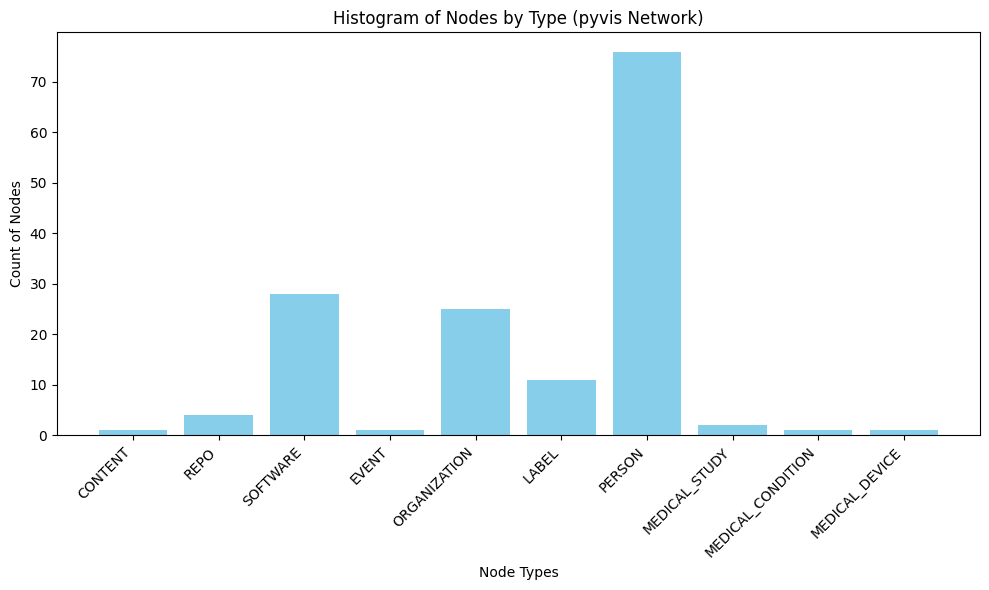

Histogram data:
CONTENT: 1
REPO: 4
SOFTWARE: 28
EVENT: 1
ORGANIZATION: 25
LABEL: 11
PERSON: 76
MEDICAL_STUDY: 2
MEDICAL_CONDITION: 1
MEDICAL_DEVICE: 1


In [ ]:
            # Query the resulting knowledge graph for the content
            graph = await query_contents_graph(content_id)

            if graph is not None:
                g = create_pyvis_contents_graph(graph)

                g.set_options("""
                var options = {
                    "physics": {
                        "forceAtlas2Based": {
                            "gravitationalConstant": -50,
                            "centralGravity": 0.01,
                            "springLength": 100,
                            "springConstant": 0.08
                        },
                        "maxVelocity": 50,
                        "solver": "forceAtlas2Based",
                        "timestep": 0.35,
                        "stabilization": {
                            "iterations": 100
                        }
                    }
                    }
                """)

                # render with random file name
                graph_html = g.generate_html(f"graph_{random.randint(0, 1000)}.html")

                # Inject FontAwesome CSS
                font_awesome_link = '<script src="https://kit.fontawesome.com/2c74303849.js" crossorigin="anonymous"></script>'
                graph_html = graph_html.replace('<head>', f'<head>{font_awesome_link}')

                display(HTML(graph_html))

                plot_pyvis_histogram(graph)

In [ ]:
time.sleep(5) # NOTE: give it a little time for all usage records to be processed, so we report on all the credits

credits = await lookup_credits(correlation_id)

if credits is not None:
    report['Claude 3.5 Sonnet (2024-06-20)'] = credits.credits

    display(Markdown(f"### Credits used: {credits.credits:.6f}"))
    print(f"- storage [{credits.storage_ratio:.2f}%], compute [{credits.compute_ratio:.2f}%]")
    print(f"- embedding [{credits.embedding_ratio:.2f}%], completion [{credits.completion_ratio:.2f}%]")
    print(f"- ingestion [{credits.ingestion_ratio:.2f}%], indexing [{credits.indexing_ratio:.2f}%], preparation [{credits.preparation_ratio:.2f}%], extraction [{credits.extraction_ratio:.2f}%], enrichment [{credits.enrichment_ratio:.2f}%], publishing [{credits.publishing_ratio:.2f}%]")
    print(f"- search [{credits.search_ratio:.2f}%], conversation [{credits.conversation_ratio:.2f}%]")
    print()

usage = await lookup_usage(correlation_id)

if usage is not None:
    display(Markdown(f"### Usage records:"))

    for record in usage:
        dump_usage_record(record)
    print()


### Credits used: 19.801310

- storage [0.04%], compute [2.47%]
- embedding [0.29%], completion [75.40%]
- ingestion [0.00%], indexing [0.00%], preparation [21.80%], extraction [0.00%], enrichment [0.00%], publishing [0.00%]
- search [0.00%], conversation [0.00%]



### Usage records:

2024-12-15T16:47:15.442Z: Serverless compute
- Workflow [Entity Event] took 0:03:40.894486, used credits [0.39770211]
- CONTENT [2b8dd3a7-43d9-4c5d-a13d-f6f9666b6153]

2024-12-15T16:47:14.932Z: GraphQL
- Operation took 0:00:00.573701, used credits [0.00000000]
- Request:
mutation IngestUri($name: String, $uri: URL!, $id: ID, $isSynchronous: Boolean, $workflow: EntityReferenceInput, $collections: [EntityReferenceInput!], $correlationId: String) { ingestUri(name: $name, uri: $uri, id: $id, workflow: $workflow, collections: $collections, isSynchronous: $isSynchronous, correlationId: $correlationId) { id name state type fileType mimeType uri collections { id name } } }
- Variables:
{"uri":"\"https:\\/\\/arxiv.org\\/pdf\\/1909.02309\"","isSynchronous":"true","workflow":"{ id: \"1e3027a2-7c19-4328-9e9c-ff2b26e3ed86\" }","correlationId":"\"2024-12-15T16:43:33.453602\""}
- Response:
{"data":{"ingestUri":{"id":"2b8dd3a7-43d9-4c5d-a13d-f6f9666b6153","name":"1909.02309","state":"FINISHED","type":

Summarize results

In [ ]:
display(Markdown('# Compiled Results'))

for result in report:
    display(Markdown(f"**{result}:** {report[result]:.6f} credits"))

# Compiled Results

**Claude 3.5 Sonnet (2024-06-20):** 19.801310 credits

Ask question

In [ ]:
prompt = input("Ask a question about the podcast: ")

if prompt is not None:
    completion_specification_id = await create_openai_completion_specification(enums.OpenAIModels.GPT4O_128K_20240806)

    if completion_specification_id is not None:
        print(f'Created completion specification [{completion_specification_id}].')

        conversation_id = await create_conversation(completion_specification_id)

        if conversation_id is not None:
            print(f'Created conversation [{conversation_id}].')

            message, graph = await prompt_conversation(conversation_id, prompt)

            if message is not None:
                display(Markdown('### Conversation:'))
                display(Markdown(f'**User:**\n{prompt}'))
                display(Markdown(f'**Assistant:**\n{message}'))
                print()

            await delete_conversation(conversation_id)

Ask a question about the podcast: what are the issues of china invade taiwan
Created completion specification [1c215a9c-992b-4c29-8610-cf32931f0863].
Created conversation [83d2334c-73d4-41d8-8801-d25e73ca256a].


### Conversation:

**User:**
what are the issues of china invade taiwan

**Assistant:**
The potential issues surrounding a hypothetical invasion of Taiwan by China are complex and multifaceted, involving geopolitical, economic, and humanitarian dimensions.

1. **Geopolitical Tensions**: An invasion would significantly escalate tensions in the Asia-Pacific region, potentially drawing in the United States and its allies, who have strategic interests in maintaining stability and supporting Taiwan. This could lead to a broader military conflict, impacting global security.

2. **Economic Impact**: Taiwan is a critical player in the global semiconductor industry, and any disruption could have severe consequences for global supply chains, affecting industries from electronics to automotive. The economic repercussions would be felt worldwide, potentially leading to a global economic downturn.

3. **Humanitarian Concerns**: An invasion would likely result in significant loss of life and displacement of people, creating a humanitarian crisis. The international community would face challenges in providing aid and support to affected populations.

4. **International Relations**: Such an action would likely lead to widespread condemnation and potential sanctions against China, further isolating it on the international stage. This could alter global alliances and trade relationships, with long-term implications for international diplomacy.

5. **Regional Stability**: The invasion could destabilize the region, affecting neighboring countries and potentially leading to a realignment of regional powers. This instability could have lasting effects on peace and security in Asia.

Overall, the consequences of a Chinese invasion of Taiwan would be profound, affecting not only the immediate region but also having far-reaching implications for global politics, economics, and humanitarian efforts.